# 2. Vectors of KPIs

### Import requremental packages

In [2]:
import networkx as nx
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

### Read data

In [3]:
with open('../data/forwards_e_2019.jsonl') as f:
    text = f.read()[0:-2]+']'
    forwards = json.loads(text)
    
G_bipartite = nx.read_gpickle('graphs/1.4_bipartite_graph.gpickle')

## 2.1 Create dictionary of unique messages in the dataset

In [6]:
messages_dict = {}
for f in forwards:
    if 'text' in f['row'].keys():
        message = f['row']['text']
        if message in messages_dict.keys():
            pass
        else:
            messages_dict[message] = [f for f in forwards if f['row']['text'] == message]
    else:
        pass

print("Number of unique messages:", len(messages_dict.keys()))

Number of unique messages: 29902


In [9]:
# save messages dictionary
with open('messages.json', 'w') as f:
    json.dump(messages_dict, f)

## 2.2 Count KPIs for each node per each message

In [27]:
ment = [n for n, d in G_bipartite.nodes(data=True) if d['bipartite'] == "mentioned"]

with open('data/messages.json', 'r') as f:
    messages_dict = json.loads(f.read())

In [32]:
vectors = {}

def count_kpis(channel_name, mentions, forwarders, G):    
    # author's KPIs
    my_strength = 0
    their_weakness = 0
    author_kpi = 0
        
    # distributor's KPI
    uniqueness = 0
    fertility = 0
    humility = 0
    verse_humility = 0
    diversity = 0
    dist_kpi = 0
        
    if channel_name in [mention['row']['mentioned_channel'] for mention in mentions]:
        # my strength
        my_strength = len(mentions)
            
        #their weakness
        their_weakness = sum([len(list(G.neighbors(n))) for n in forwarders])
        
        # author's kpi
        author_kpi = my_strength / their_weakness    
        
    if channel_name in [mention['row']['channel'] for mention in mentions]:
        authors = [[mention['row']['mentioned_channel'], mention['row']['post_date']] for mention in mentions if mention['row']['channel'] == channel_name]
        author = sorted(authors, key=lambda x: x[1])[0][0]
            
        # uniquness
        uniqueness = len(mentions)
            
        # fertility
        fertility = sum([G[e[0]][e[1]]['weight'] for e in G.edges(channel_name+'__forw')])
            
        # humility
        humility = G.get_edge_data(channel_name+'__forw', author+'__ment')['weight']
        
        # verse humility
        if G.get_edge_data(channel_name+'__ment', author+'__forw'):
            verse_humility = G.get_edge_data(channel_name+'__ment', author+'__forw')['weight']
            
        # diversity
        diversity = len(list(G.neighbors(channel_name+'__forw')))
        
        
        # distributor's kpi
        if fertility == 0 or diversity == 0:
            dist_kpi = -uniqueness * humility
        else:                                                         
            dist_kpi = -(uniqueness / fertility) * (humility / diversity)
     
    total_kpi = author_kpi + dist_kpi
    
    return my_strength, their_weakness, uniqueness, fertility, humility, verse_humility, diversity, author_kpi, dist_kpi, total_kpi

In [33]:
for i, m in enumerate(ment):
    channel_name = m.replace("__ment", "")
    print("Start №", i, ":", m)
    
    vectors[channel_name] = {'my_strength': [], 
                             'their_weakness': [],
                            'uniqueness': [],
                            'fertility': [],
                            'humility': [],
                            'verse_humility': [],
                            'diversity': [],
                            'author_kpi': [],
                            'dist_kpi': [],
                            'total_kpi': []}
    
    for message, mentions in messages_dict.items():
        forwarders = list(set([mention['row']['channel']+'__forw' for mention in mentions]))
        
        my_strength, their_weakness, uniqueness, fertility, humility, verse_humility, diversity, author_kpi, dist_kpi, total_kpi = count_kpis(channel_name, mentions, forwarders, G_bipartite)
                        
            
        vectors[channel_name]['my_strength'].append(my_strength)
        vectors[channel_name]['their_weakness'].append(their_weakness)
        
        vectors[channel_name]['uniqueness'].append(uniqueness)
        vectors[channel_name]['fertility'].append(fertility)
        vectors[channel_name]['humility'].append(humility)
        vectors[channel_name]['verse_humility'].append(verse_humility)
        vectors[channel_name]['diversity'].append(diversity)
        
        vectors[channel_name]['author_kpi'].append(author_kpi)
        vectors[channel_name]['dist_kpi'].append(dist_kpi)
        vectors[channel_name]['total_kpi'].append(total_kpi)
    
    print("Done: ", m)
    
    # write file
    with open('data/vectors.json', 'w') as f:
        json.dump(vectors, f)

Start № 0 : dimsmirnov175__ment
Done:  dimsmirnov175__ment
Start № 1 : russianfuture__ment
Done:  russianfuture__ment
Start № 2 : obrazbuduschego__ment
Done:  obrazbuduschego__ment
Start № 3 : yudenich__ment
Done:  yudenich__ment
Start № 4 : SerpomPo__ment
Done:  SerpomPo__ment
Start № 5 : pzdcofficial__ment
Done:  pzdcofficial__ment
Start № 6 : polittemnik__ment
Done:  polittemnik__ment
Start № 7 : mysly__ment
Done:  mysly__ment
Start № 8 : SergeyKolyasnikov__ment
Done:  SergeyKolyasnikov__ment
Start № 9 : otsuka_bld__ment
Done:  otsuka_bld__ment
Start № 10 : kremlebezBashennik__ment
Done:  kremlebezBashennik__ment
Start № 11 : popyachsa__ment
Done:  popyachsa__ment
Start № 12 : oko_ok__ment
Done:  oko_ok__ment
Start № 13 : minpravda__ment
Done:  minpravda__ment
Start № 14 : Ivorytowers__ment
Done:  Ivorytowers__ment
Start № 15 : mig41__ment
Done:  mig41__ment
Start № 16 : legitimniy__ment
Done:  legitimniy__ment
Start № 17 : mediakiller__ment
Done:  mediakiller__ment
Start № 18 : pol

## 2.3 Relations and Collinearity between KPIs

In [34]:
with open('data/vectors.json', 'r') as f:
    vectors = json.loads(f.read())

def avg(l):
    return sum(l) / len(l)

In [38]:
kpis = {'my_strength': [], 
        'their_weakness': [],
        'uniqueness': [],
        'fertility': [],
        'humility': [],
        'verse_humility': [],
        'diversity': [],
        'author_kpi': [],
        'dist_kpi': [],
        'total_kpi': []}


for k, v in vectors.items():    
    kpis['my_strength'].append(avg(v['my_strength']))
    kpis['their_weakness'].append(avg(v['their_weakness']))
    kpis['uniqueness'].append(avg(v['uniqueness']))
    kpis['fertility'].append(avg(v['fertility']))
    kpis['humility'].append(avg(v['humility']))
    kpis['verse_humility'].append(avg(v['verse_humility']))
    kpis['diversity'].append(avg(v['diversity']))
    kpis['author_kpi'].append(avg(v['author_kpi'])),
    kpis['dist_kpi'].append(avg(v['dist_kpi']))
    kpis['total_kpi'].append(avg(v['total_kpi']))

df_kpis = pd.DataFrame.from_dict(kpis)

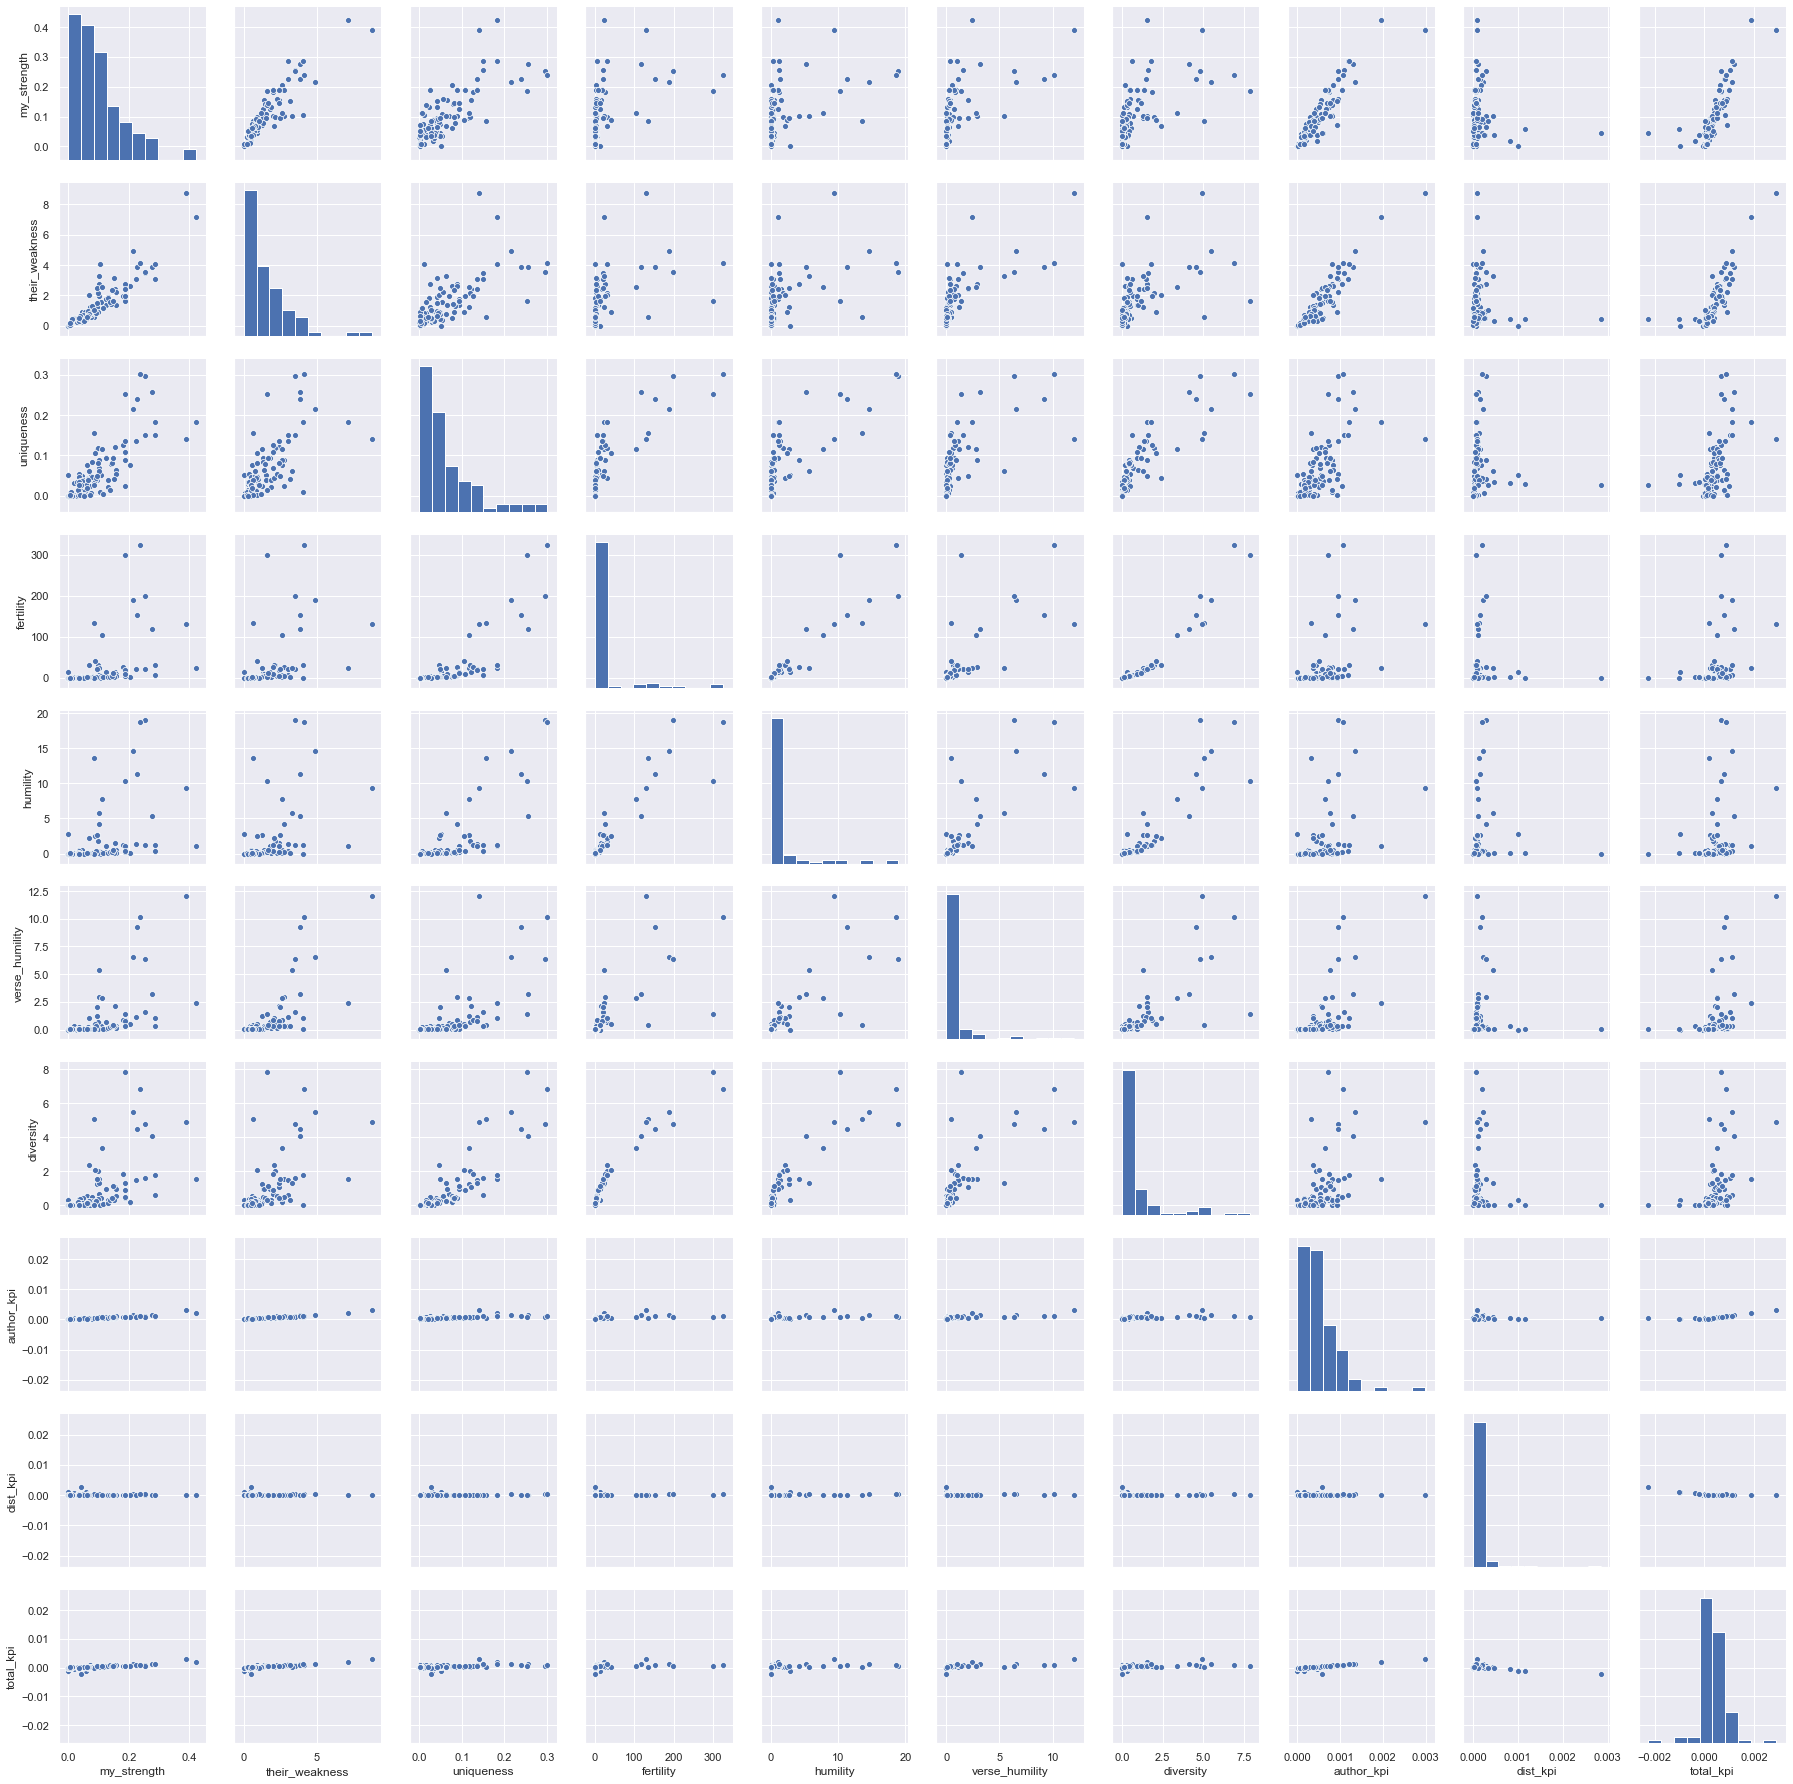

In [40]:
sns.set()
sns.pairplot(df_kpis)
plt.show()

In [41]:
corr = df_kpis.corr(method='pearson', min_periods=1)
corr

,my_strength,their_weakness,uniqueness,fertility,humility,verse_humility,diversity,author_kpi,dist_kpi,total_kpi
my_strength,1.000000,0.906247,0.768959,0.479203,0.450743,0.598458,0.588007,0.903812,-0.093695,0.777145
their_weakness,0.906247,1.000000,0.671859,0.478170,0.501369,0.736597,0.589105,0.931709,-0.072464,0.786602
uniqueness,0.768959,0.671859,1.000000,0.805463,0.777442,0.681007,0.865420,0.617164,0.009632,0.486335
fertility,0.479203,0.478170,0.805463,1.000000,0.927688,0.744218,0.957112,0.435624,0.012985,0.339553
humility,0.450743,0.501369,0.777442,0.927688,1.000000,0.810405,0.907640,0.432586,0.056879,0.310693
verse_humility,0.598458,0.736597,0.681007,0.744218,0.810405,1.000000,0.754924,0.672305,0.033216,0.516101
diversity,0.588007,0.589105,0.865420,0.957112,0.907640,0.754924,1.000000,0.546723,-0.022405,0.449459
author_kpi,0.903812,0.931709,0.617164,0.435624,0.432586,0.672305,0.546723,1.000000,-0.001439,0.798282
dist_kpi,-0.093695,-0.072464,0.009632,0.012985,0.056879,0.033216,-0.022405,-0.001439,1.000000,-0.603432
total_kpi,0.777145,0.786602,0.486335,0.339553,0.310693,0.516101,0.449459,0.798282,-0.603432,1.000000


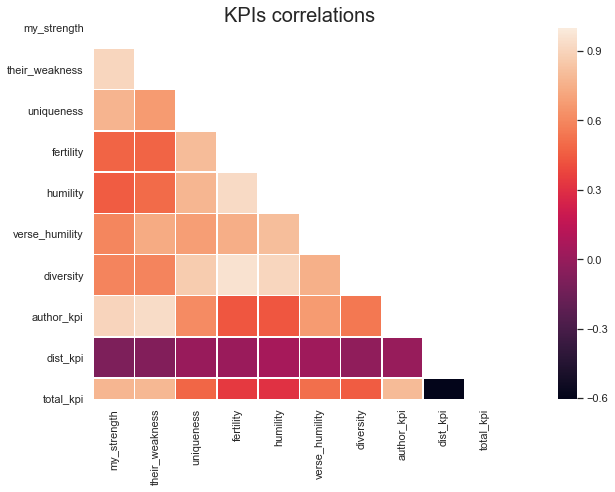

In [121]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 7))
    ax = sns.heatmap(corr, mask=mask, linewidth=.5, square=True)
    ax.set_title("KPIs correlations", fontsize=20)
    f.tight_layout()

## 2.4 Distance between vectors

In [43]:
def count_cos(vectors, kpi_name):
    arr = []
    for k, v in vectors.items():
        row = []
        for k1, v1 in vectors.items():
            a = np.array(v[kpi_name])
            b = np.array(v1[kpi_name])

            aa = a.reshape(1,len(v[kpi_name]))
            ba = b.reshape(1,len(v1[kpi_name]))
            cos_lib = cosine_similarity(aa, ba)

            row.append(cos_lib[0][0])
        arr.append(row)
    
    return arr

In [46]:
kpi_names = ['my_strength', 'their_weakness', 'uniqueness', 'fertility', 'humility', 'verse_humility', 'diversity',
            'author_kpi', 'dist_kpi', 'total_kpi']

coss = {}

for kpi_name in kpi_names:
    coss[kpi_name] = count_cos(vectors, kpi_name)
    print("Done:", kpi_name)

Done: my_strength
Done: their_weakness
Done: uniqueness
Done: fertility
Done: humility
Done: verse_humility
Done: diversity
Done: author_kpi
Done: dist_kpi
Done: total_kpi


In [48]:
# save a file
with open('data/coss_distances.json', 'w') as f:
    json.dump(coss, f)

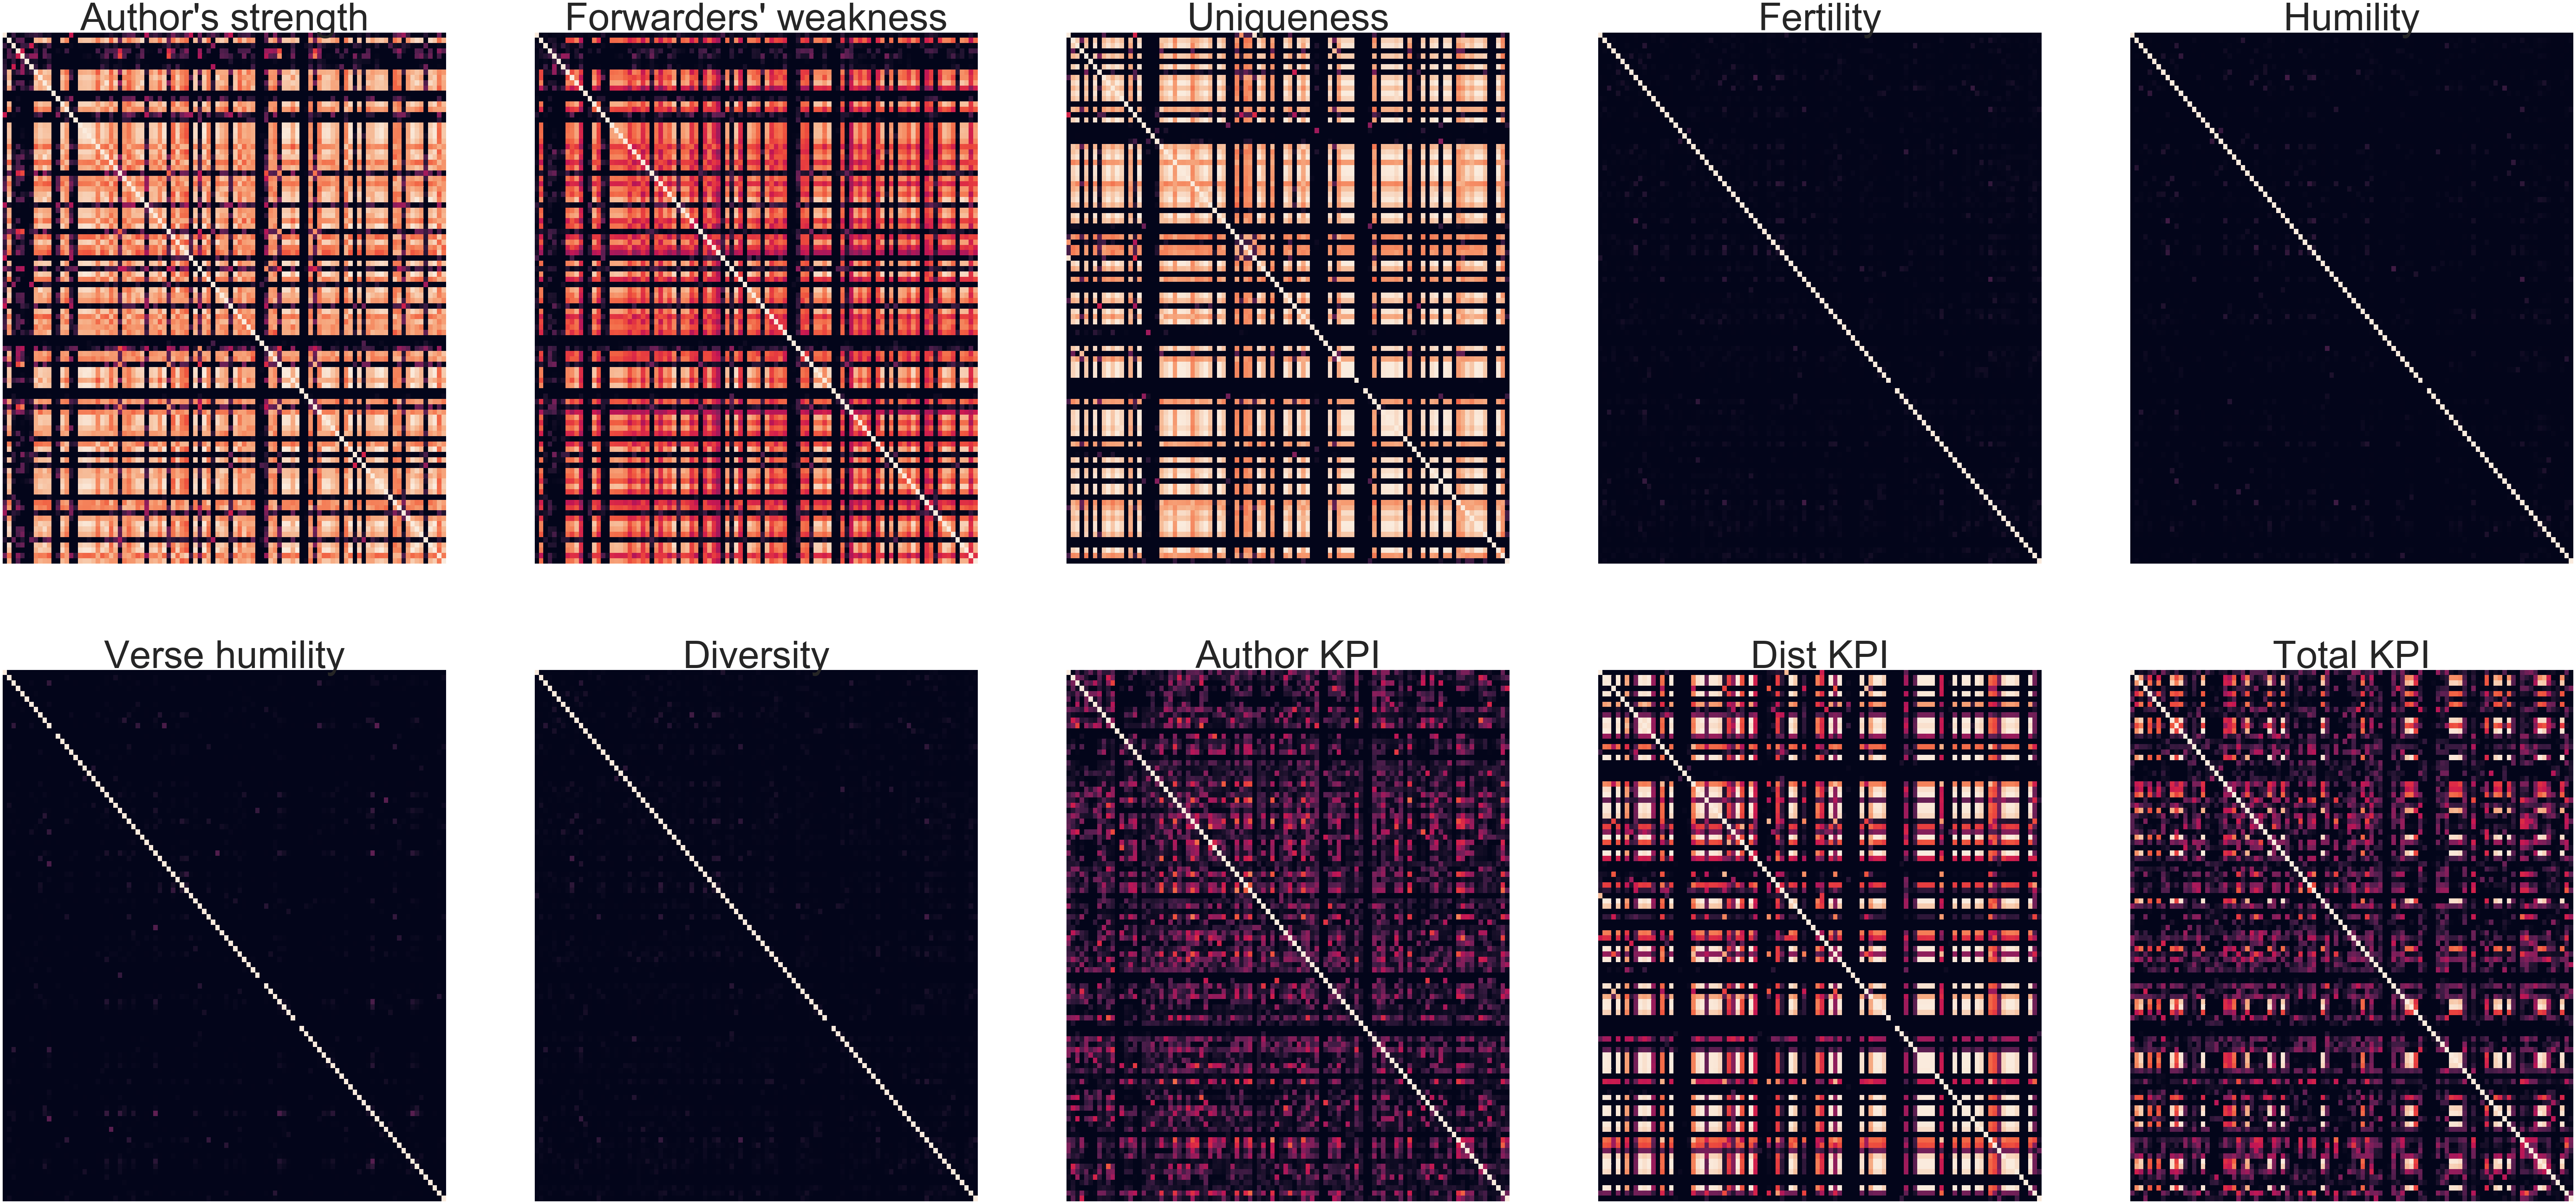

In [4]:
# read file
with open('data/coss_distances.json', 'r') as f:
    coss = json.loads(f.read())

vmin = 0
vmax = 1
sns.set()

fig, axs = plt.subplots(figsize=(120,56), ncols=5, nrows=2, gridspec_kw=dict(width_ratios=[6,6,6,6,6]))

sns.heatmap(coss['my_strength'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[0][0], vmin=vmin, vmax=vmax)
axs[0][0].set_title("Author's strength", fontsize=100)

sns.heatmap(coss['their_weakness'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[0][1], vmin=vmin, vmax=vmax)
axs[0][1].set_title("Forwarders' weakness", fontsize=100)

sns.heatmap(coss['uniqueness'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[0][2], vmin=vmin, vmax=vmax)
axs[0][2].set_title('Uniqueness', fontsize=100)

sns.heatmap(coss['fertility'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[0][3], vmin=vmin, vmax=vmax)
axs[0][3].set_title('Fertility', fontsize=100)

sns.heatmap(coss['humility'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[0][4], vmin=vmin, vmax=vmax)
axs[0][4].set_title('Humility', fontsize=100)

sns.heatmap(coss['verse_humility'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[1][0], vmin=vmin, vmax=vmax)
axs[1][0].set_title('Verse humility', fontsize=100)

sns.heatmap(coss['diversity'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[1][1], vmin=vmin, vmax=vmax)
axs[1][1].set_title('Diversity', fontsize=100)

sns.heatmap(coss['author_kpi'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[1][2], vmin=vmin, vmax=vmax)
axs[1][2].set_title('Author KPI', fontsize=100)

sns.heatmap(coss['dist_kpi'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[1][3], vmin=vmin, vmax=vmax)
axs[1][3].set_title('Dist KPI', fontsize=100)

sns.heatmap(coss['total_kpi'], xticklabels=False, yticklabels=False, cbar=False, ax=axs[1][4], vmin=vmin, vmax=vmax)
axs[1][4].set_title('Total KPI', fontsize=100)

plt.show()